In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import torch.optim as optim
import random
import numpy as np
from torchvision import models

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("device using: ", device)

device using:  cuda


In [3]:
def set_seed(seed=42):

    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    np.random.seed(seed)
    random.seed(seed)

    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

In [4]:
import os, shutil
from PIL import Image

src = "/kaggle/input/microsoft-catsvsdogs-dataset/PetImages"
dst = "/kaggle/working/PetImages"

if not os.path.exists(dst):
    shutil.copytree(src, dst)

# Now clean in /kaggle/working
for category in ["Cat", "Dog"]:
    folder = os.path.join(dst, category) 
    for file in os.listdir(folder): 
        fpath = os.path.join(folder, file)
        try:
            img = Image.open(fpath)
            img.verify()
        except:
            os.remove(fpath)

/usr/local/lib/python3.11/dist-packages/PIL/TiffImagePlugin.py:950: UserWarning: Truncated File Read
  warnings.warn(str(msg))


In [5]:
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),  
    transforms.ToTensor(),
    transforms.RandomErasing(p=0.5, scale=(0.02, 0.1)),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # standard ImageNet normalization
])

In [6]:
val_test_transform = transforms.Compose([transforms.Resize((256, 256)),
                                        transforms.CenterCrop(224),
                                        transforms.ToTensor(), 
                                        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

In [7]:
dataset = datasets.ImageFolder(root=dst)

In [8]:
print(len(dataset))

24998


In [9]:
print(dataset.classes)

['Cat', 'Dog']


In [10]:
train_size = int(0.7*len(dataset))
val_size = int(0.1*len(dataset))
test_size = len(dataset) - train_size - val_size

train_set, val_set, test_set = random_split(dataset, [train_size, val_size, test_size])

In [11]:
# Custom wrapper
class TransformDataset(torch.utils.data.Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    
    def __getitem__(self, idx):
        x, y = self.subset[idx]
        if self.transform:
            x = self.transform(x)
        return x, y
    
    def __len__(self):
        return len(self.subset)

train_dataset = TransformDataset(train_set, train_transform)
val_dataset = TransformDataset(val_set, val_test_transform)
test_dataset = TransformDataset(test_set, val_test_transform)

In [12]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=3, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64,  num_workers=3, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64,  num_workers=3, pin_memory=True)

In [13]:
Classifier = models.resnet18(pretrained=True)

# Freeze all layers
for param in Classifier.parameters():
    param.requires_grad = False

# Replace the last layer
num_ftrs = Classifier.fc.in_features
Classifier.fc = nn.Linear(num_ftrs, 2)  # 2 classes: dog & cat
Classifier = Classifier.to(device)


/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 194MB/s]


In [14]:
optimizer = optim.Adam(Classifier.parameters(), lr=1e-3)
Loss = nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=3, factor=0.5, min_lr=1e-6)

In [15]:
epochs = 24 #I ran it for more than 24 but it didnt improve beyond 24 so I ran it again with just epoch=24 to check if i get same results and if 14 extra epochs caused any kind of overfitting or not
es_patience = 14
counter = 0
best_val_loss = float('inf')     #float('inf') is basically Python’s way of saying “this number is larger than anything I can represent” → i.e. positive infinity
delta=1e-4

for epoch in range(epochs):
    Classifier.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = Classifier(images)
        loss = Loss(outputs,labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    #Validation part
    total_val_loss=0
    Classifier.eval()
    total_samples = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = Classifier(images)
            loss = Loss(outputs, labels) # mean loss per sample
            total_val_loss += loss*labels.size(0) #total loss per batch in each loop, eventually at the end, total loss on whole data
            total_samples += labels.size(0)
        avg_val_loss = total_val_loss / total_samples
        scheduler.step(avg_val_loss)

    #Early stopping
    if avg_val_loss < best_val_loss-delta:
        best_val_loss = avg_val_loss
        torch.save(Classifier.state_dict(), "best_model_trial.pth")
        counter=0
    else:
        counter+=1
        if counter>es_patience:
            print("Early stopping triggered.")
            break
    print(f"Epoch:{(epoch+1)}/{epochs} | Val_loss: {avg_val_loss:.4f} | Patience Counter: {counter}")

Epoch:1/24 | Val_loss: 0.0653 | Patience Counter: 0
Epoch:2/24 | Val_loss: 0.0570 | Patience Counter: 0
Epoch:3/24 | Val_loss: 0.0501 | Patience Counter: 0
Epoch:4/24 | Val_loss: 0.0582 | Patience Counter: 1
Epoch:5/24 | Val_loss: 0.0651 | Patience Counter: 2
Epoch:6/24 | Val_loss: 0.0468 | Patience Counter: 0
Epoch:7/24 | Val_loss: 0.0577 | Patience Counter: 1
Epoch:8/24 | Val_loss: 0.0461 | Patience Counter: 0
Epoch:9/24 | Val_loss: 0.0477 | Patience Counter: 1
Epoch:10/24 | Val_loss: 0.0584 | Patience Counter: 2
Epoch:11/24 | Val_loss: 0.0463 | Patience Counter: 3
Epoch:12/24 | Val_loss: 0.0555 | Patience Counter: 4
Epoch:13/24 | Val_loss: 0.0449 | Patience Counter: 0
Epoch:14/24 | Val_loss: 0.0454 | Patience Counter: 1
Epoch:15/24 | Val_loss: 0.0466 | Patience Counter: 2
Epoch:16/24 | Val_loss: 0.0454 | Patience Counter: 3
Epoch:17/24 | Val_loss: 0.0449 | Patience Counter: 4
Epoch:18/24 | Val_loss: 0.0477 | Patience Counter: 5
Epoch:19/24 | Val_loss: 0.0446 | Patience Counter: 0
Ep

In [18]:
#Testing
Classifier.eval()
correct=0
total=0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = Classifier(images)
        _, predicted = torch.max(outputs, dim=1)
        total += labels.size(0)
        correct+=(predicted==labels).sum().item()
    test_accuracy=100*correct/total
    print(f"Test Accuracy: {test_accuracy:.2f}%")
    

Test Accuracy: 98.42%


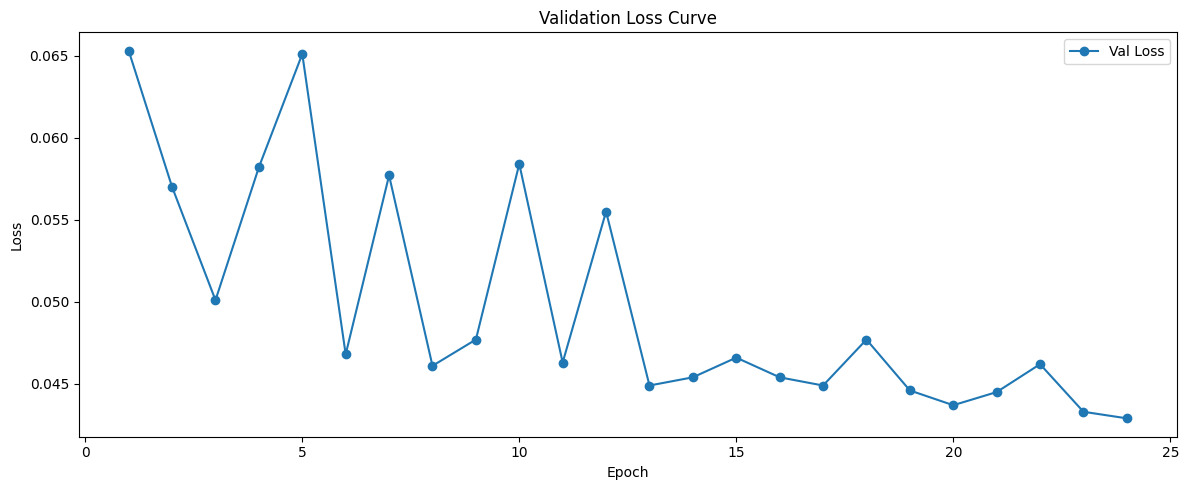

In [19]:
import matplotlib.pyplot as plt


val_losses = [
    0.0653, 0.0570, 0.0501, 0.0582, 0.0651, 
    0.0468, 0.0577, 0.0461, 0.0477, 0.0584, 
    0.0463, 0.0555, 0.0449, 0.0454, 0.0466, 
    0.0454, 0.0449, 0.0477, 0.0446, 0.0437, 
    0.0445, 0.0462, 0.0433, 0.0429
]

epochs = range(1, len(val_losses) + 1)

plt.figure(figsize=(12,5))


plt.plot(epochs, val_losses, marker='o', label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Validation Loss Curve")
plt.legend()

plt.tight_layout()
plt.show()
